In [1]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 128
    eval_batch_size = 128
    num_epochs = 20
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
    scale = 0.18215

config = TrainingConfig()

In [2]:
!pip install diffusers[training]
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

print(len(dataset))

/home/amcalinden/miniconda3/envs/diffusion2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.


1000


1000


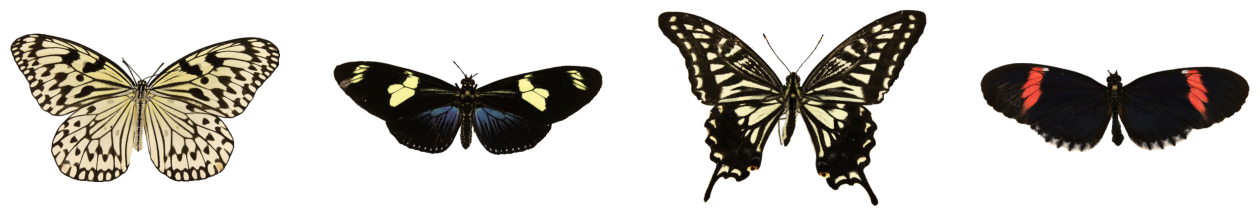

In [3]:
import matplotlib.pyplot as plt

print(len(dataset))

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [4]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]), # transform from [0, 1] to [-1, 1]
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [5]:
import torch
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [6]:
# model = UNet2DModel(
#     sample_size=config.image_size,  # the target image resolution
#     in_channels=3,  # the number of input channels, 3 for RGB images
#     out_channels=3,  # the number of output channels
#     layers_per_block=2,  # how many ResNet layers to use per UNet block
#     block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
#     down_block_types=(
#         "DownBlock2D",  # a regular ResNet downsampling block
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",
#         "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
#         "DownBlock2D",
#     ),
#     up_block_types=(
#         "UpBlock2D",  # a regular ResNet upsampling block
#         "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#     ),
# )

from diffusers import UNet2DConditionModel
from diffusers import AutoencoderKL 

# same as the one used in stable diffusion
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float32)
vae.eval()
vae.requires_grad_(False)

unet = UNet2DConditionModel(cross_attention_dim = (768),
                                    down_block_types = ("CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "DownBlock2D"),
                                    block_out_channels= (320, 640, 1280),
                                    up_block_types = ("UpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D"),
                                    ).to(torch.float32)
unet.requires_grad_(True)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [7]:
# sample_image = dataset[0]["images"].unsqueeze(0)
# print("Input shape:", sample_image.shape)

# cond_tensor = torch.ones((1, 77, 768))
# init_image = sample_image * 2.0 - 1.0
# init_image = init_image.to(dtype=torch.float32)
# with torch.no_grad():
#     img_latents = vae.encode(init_image).latent_dist.sample() # this constant scales vae output down to make it gaussian w std 1
#     img_latents  = img_latents * 0.18215 

# print("Output shape:", unet(img_latents, timestep=0, encoder_hidden_states = cond_tensor).sample.shape)


import torch
# from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# noise = torch.randn(sample_image.shape)
# timesteps = torch.LongTensor([50])
# noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

# Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [8]:
import torch.nn.functional as F

# noise = torch.randn(img_latents.shape)
# timesteps = torch.LongTensor([50])
# noisy_image = noise_scheduler.add_noise(img_latents, noise, timesteps)


# noise_pred = unet(noisy_image, timestep = timesteps, encoder_hidden_states = cond_tensor).sample
# loss = F.mse_loss(noise_pred, noise)

In [9]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [10]:
from torchvision.utils import make_grid
from PIL import Image
import torch
import os

def make_image_grid(images, cols=4):
    grid = make_grid(images, nrow=cols)
    ndarr = (grid * 255).byte().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray(ndarr)

def evaluate(config, epoch, pipeline, vae):
    # Set eval mode just in case
    vae.eval()
    pipeline.unet.eval()

    batch_size = config.eval_batch_size
    device = pipeline.device

    # Dummy conditioning: [batch, 77, 768]
    cond_tensor = torch.ones((batch_size, 77, 768), device=device)

    # Create random latent noise in the shape expected by your VAE
    latents = torch.randn(
        (batch_size, 4, 16, 16),
        generator=torch.Generator(device=device).manual_seed(config.seed),
        device=device
    )

    with torch.no_grad():
        # Diffuse over timesteps
        for t in pipeline.scheduler.timesteps:
            latent_input = pipeline.scheduler.scale_model_input(latents, t)
            noise_pred = pipeline.unet(latent_input, t, encoder_hidden_states=cond_tensor).sample
            latents = pipeline.scheduler.step(noise_pred, t, latents).prev_sample

        # Scale back from latent space
        latents = latents / config.scale
        images = vae.decode(latents).sample
        images = (images / 2 + 0.5).clamp(0, 1)  # Scale to [0,1] range

    # Save image grid
    img_grid = make_image_grid(images, cols=4)
    sample_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(sample_dir, exist_ok=True)
    img_grid.save(os.path.join(sample_dir, f"{epoch:04d}.png"))


In [11]:
from accelerate import Accelerator
from tqdm.auto import tqdm
import os
from diffusers import DDPMPipeline

def train_loop(config, unet, noise_scheduler, optimizer, train_dataloader, lr_scheduler, vae):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    vae = vae.to(accelerator.device)
    vae.eval()  # optional but good if you're not training it

    # Now you train the model
    losses = []
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            init_image = batch["images"]
            # init_image = init_image * 2 - 1
            # print('minmax:', init_image.max(), init_image.min())
            # Sample noise to add to the images
            init_image = init_image.to(dtype=torch.float32)

            # they are already on -1, 1
            # print('minmax:', init_image.max(), init_image.min())

            with torch.no_grad():
                img_latents = vae.encode(init_image).latent_dist.sample() # this constant scales vae output down to make it gaussian w std 1
                img_latents  = img_latents * config.scale

            noise = torch.randn(img_latents.shape, device=init_image.device)
            bs = init_image.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=init_image.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(img_latents, noise, timesteps)

            with accelerator.accumulate(unet):
                # Predict the noise residual
                cond_tensor = torch.ones((bs, 77, 768)).to(accelerator.device)
                noise_pred = unet(noisy_images, timesteps, encoder_hidden_states = cond_tensor, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            total_loss += loss.detach().item()
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        losses.append(total_loss / len(train_dataloader))

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(unet), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, vae)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)
    return losses

In [12]:
losses = train_loop(config, unet, noise_scheduler, optimizer, train_dataloader, lr_scheduler, vae)

Epoch 19: 100%|██████████| 8/8 [01:22<00:00, 10.29s/it, loss=0.135, lr=3.2e-5, step=159]


Text(0, 0.5, 'Loss')

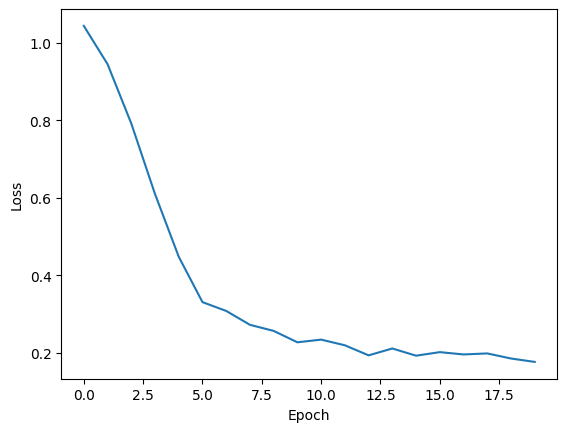

In [13]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

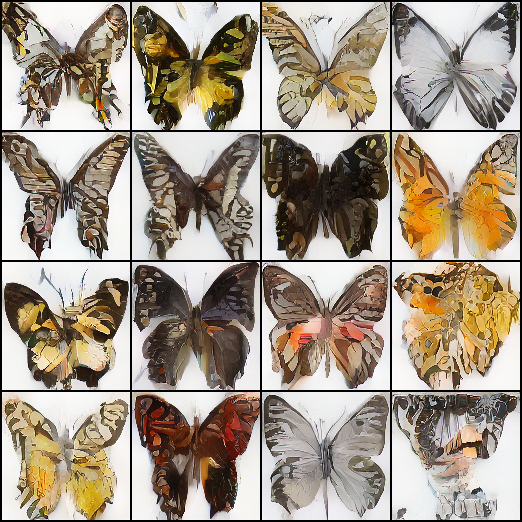

In [14]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])